# **Imports**


In [1]:
# Custom libraries
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.CNNPreprocessor import CNNPreprocessor
from tools.CNNTrainer import CNNTrainer
from tools.CNNEvaluator import CNNEvaluator


# Custom PyTorch models
from models.PyTorchCNNClassifier import PyTorchCNNClassifier

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


# **Data Load**


In [3]:
# Step 1: Load Data using DataLoader
train_loader = DataLoader(dataset_type="train", path="./db/seg_train")
train_dataset = train_loader.load_data()

# Initialize the data loader for a test dataset
test_loader = DataLoader(dataset_type="test", path="./db/seg_test")
test_dataset = test_loader.load_data()

# Initialize the data loader for a val dataset
val_loader = DataLoader(dataset_type="val", path="./db/seg_pred")
val_dataset = val_loader.load_unlabeled_data()

In [4]:
print(f"Train dataset type: {type(train_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")
print(f"Val dataset type: {type(val_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Val dataset type: <class 'list'>


# **EDA**


In [5]:
eda = EDA(train_dataset, train_dataset.classes)

In [6]:
# eda.show_sample_images(num_images=6)

In [7]:
# eda.show_images_from_each_class()

In [8]:
# eda.plot_class_distribution()

In [9]:
# eda.show_image_shape()

# **Preprocessing**


In [10]:
preprocessor = CNNPreprocessor()

In [11]:
preprocessor.help()

Available transformations and their parameters:
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| Transformation       | Description                                                          | Parameters                                                         |
+======================+======================================================================+====================================================================+
| RandomResizedCrop    | Randomly crops a part of the image and resizes it to the given size. | size: (int): Target size of the crop.                              |
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| RandomHorizontalFlip | Randomly flips the image horizontally with a given probability.      | p: (float): Probability of flip

In [12]:
# Задаем настройки трансформаций для тренировочного, валидационного и тестового наборов данных
preprocessor.set_transform_settings(
    train_transform_settings={
        "RandomResizedCrop": {"enabled": True, "size": 224},
        "RandomHorizontalFlip": {"enabled": True, "p": 0.5},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    test_transform_settings={
        "Resize": {"enabled": True, "size": 256},
        "CenterCrop": {"enabled": True, "size": 224},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    val_transform_settings={
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
)

In [13]:
# Проверим первое изображение из набора данных
img_train, label_img_train = train_dataset[0]
img_test, label_test = test_dataset[0]
img_val = val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>
Image type val: <class 'torch.Tensor'>


In [14]:
# Применение трансформаций к тренировочному датасету
transformed_train_dataset = preprocessor.transform_dataset(
    train_dataset, dataset_type="train"
)

# Применение трансформаций к тестовому датасету
transformed_test_dataset = preprocessor.transform_dataset(
    test_dataset, dataset_type="test"
)

In [15]:
print(f"Train dataset type: {type(transformed_train_dataset)}")
print(f"Test dataset type: {type(transformed_test_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


In [16]:
# Применение трансформаций к валидационному датасету
transformed_val_dataset = preprocessor.transform_unlabeled_data(val_dataset)

In [17]:
print(f"Val dataset type: {type(transformed_val_dataset)}")

Val dataset type: <class 'list'>


In [18]:
# Проверим первое изображение из набора данных
img_train, label_img_train = transformed_train_dataset[0]
img_test, label_test = transformed_test_dataset[0]
img_val = transformed_val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>
Image type val: <class 'torch.Tensor'>


In [19]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [20]:
model = PyTorchCNNClassifier(
    input_channels=3, num_classes=num_classes, random_state=42, epochs_logger=True
)

In [21]:
# param_grid = {
#     "conv_layers": [
#         [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
#     ],  # out_channels, kernel_size, stride, padding
#     "hidden_sizes": [[256, 128]],  # Fully connected layers
#     "lr": [0.001, 0.01],  # Learning rate
#     "batch_size": [16, 32],  # Batch size
#     "epochs": [10, 20],  # Number of epochs
#     "dropout_rate": [0.1, 0.3],  # Dropout rate for fully connected layers
#     "optimizer_type": ["sgd", "adam"],  # Optimizer type
#     "activation_fn": ["ReLU", "Sigmoid"],  # Activation function choices as strings
#     "pool_fn": ["MaxPool2d", "AvgPool2d"],  # Pooling function choices as strings
#     "pool_kernel_size": [2, 3],  # Pooling kernel size
#     "pool_stride": [2, 1],  # Pooling stride
#     "pool_padding": [0, 1],  # Pooling padding
# }

param_grid = {
    "conv_layers": [[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]],
    "hidden_sizes": [[256, 128]],
    "lr": [0.001],
    "batch_size": [16],
    "epochs": [10],
    "dropout_rate": [0.1],
    "optimizer_type": ["adam"],
    "activation_fn": ["ReLU"],
    "pool_fn": ["MaxPool2d"],
    "pool_kernel_size": [2],
    "pool_stride": [2],
    "pool_padding": [0],
}

In [22]:
models = {"cnn_model": model}
param_grids = {"cnn_model": param_grid}

# **Model Training**


In [23]:
model_trainer = CNNTrainer(device="cuda")

In [24]:
model_trainer.help()

=== CNNTrainer Help ===
This trainer is designed to support classification tasks using PyTorch CNN models.

Usage:
1. Initialize the CNNTrainer with the device ('cpu' or 'cuda').
   Example:
       trainer = CNNTrainer(device='cuda')

2. Create model objects and define the parameter grid for hyperparameter tuning.
   Example:
       param_grid = { "lr": [0.001, 0.01], "epochs": [10, 20] }

3. Call the `train` method with the training and test datasets, models, and parameter grid.
   Example:
       trainer.train(train_dataset, test_dataset, models={'cnn_model': model}, param_grids={'cnn_model': param_grid})


In [25]:
model_trainer.train(
    train_dataset=transformed_train_dataset,
    test_dataset=transformed_test_dataset,
    models=models,
    param_grids=param_grids,
    scoring="accuracy",
    verbose=1,
    use_progress_bar=True,
)

Training on device: cuda


Total Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Training cnn_model with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}
Training with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}

Epoch 1/10


Total Training Progress:  10%|█         | 1/10 [01:07<10:06, 67.44s/it]

Training Loss: 1.1579618734352137, Training Accuracy: 0.5445347014393616
Validation Loss: 1.0371821105400933, Validation Accuracy: 0.6346666666666667

Epoch 2/10


Total Training Progress:  20%|██        | 2/10 [02:21<09:32, 71.53s/it]

Training Loss: 0.8656299322300457, Training Accuracy: 0.6764999287444777
Validation Loss: 0.5691370249706063, Validation Accuracy: 0.799

Epoch 3/10


Total Training Progress:  30%|███       | 3/10 [03:36<08:30, 72.90s/it]

Training Loss: 0.7782418539488777, Training Accuracy: 0.715334188399601
Validation Loss: 0.5117149674135478, Validation Accuracy: 0.8243333333333334

Epoch 4/10


Total Training Progress:  40%|████      | 4/10 [04:53<07:27, 74.59s/it]

Training Loss: 0.7140421110941501, Training Accuracy: 0.7324355137523159
Validation Loss: 0.4969941140028668, Validation Accuracy: 0.826

Epoch 5/10


Total Training Progress:  50%|█████     | 5/10 [06:12<06:20, 76.14s/it]

Training Loss: 0.6845297638776634, Training Accuracy: 0.7464015961236996
Validation Loss: 0.4784187919935806, Validation Accuracy: 0.831

Epoch 6/10


Total Training Progress:  60%|██████    | 6/10 [07:31<05:08, 77.12s/it]

Training Loss: 0.6582308975907556, Training Accuracy: 0.7553797919338748
Validation Loss: 0.4716279809462263, Validation Accuracy: 0.8373333333333334

Epoch 7/10


Total Training Progress:  70%|███████   | 7/10 [08:48<03:51, 77.08s/it]

Training Loss: 0.6382703696099664, Training Accuracy: 0.7672082086361693
Validation Loss: 0.4419740852265138, Validation Accuracy: 0.8473333333333334

Epoch 8/10


Total Training Progress:  80%|████████  | 8/10 [10:05<02:34, 77.16s/it]

Training Loss: 0.6198234276290228, Training Accuracy: 0.768348296993017
Validation Loss: 0.45677969353988723, Validation Accuracy: 0.8486666666666667

Epoch 9/10


Total Training Progress:  90%|█████████ | 9/10 [11:21<01:16, 76.60s/it]

Training Loss: 0.6083877176589466, Training Accuracy: 0.7794641584722816
Validation Loss: 0.47154266808300893, Validation Accuracy: 0.8353333333333334

Epoch 10/10


Total Training Progress: 100%|██████████| 10/10 [12:37<00:00, 76.39s/it]

Training Loss: 0.5967399163769902, Training Accuracy: 0.7831694456320365


Total Training Progress: 100%|██████████| 10/10 [12:45<00:00, 76.52s/it]

Validation Loss: 0.42473152947415194, Validation Accuracy: 0.8553333333333333
Validation Accuracy for cnn_model: 0.7831694456320365

Best Model: cnn_model with score: 0.7831694456320365


In [26]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model_name = model_trainer.best_model_name

In [27]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)

{'cnn_model': <models.PyTorchCNNClassifier.PyTorchCNNClassifier object at 0x000002433A8064B0>}
{'cnn_model': {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}}
{'cnn_model': 0.7831694456320365}
cnn_model


# **Model Evaluator**


In [28]:
evaluator = CNNEvaluator()

In [29]:
evaluator.visualize_pipeline(model_name=best_model_name, best_models=best_models)

Visualizing the architecture of the model: cnn_model
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           25,690,368
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           32,896
├─ReLU: 1-15                             --
├─Dropout: 1-16                          --
├─Linear: 1-17                           774
Total params: 25,817,286
Trainable params: 25,817,286
Non-trainable params: 0


In [30]:
evaluator.display_results(
    test_dataset=transformed_test_dataset,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Validation Loss: 0.42473152947415194, Validation Accuracy: 0.8553333333333333
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.855333,0.85493,0.854461,0.856631,0.855333



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,10,"[256, 128]",0.001,adam,MaxPool2d,2,0,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.783169



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


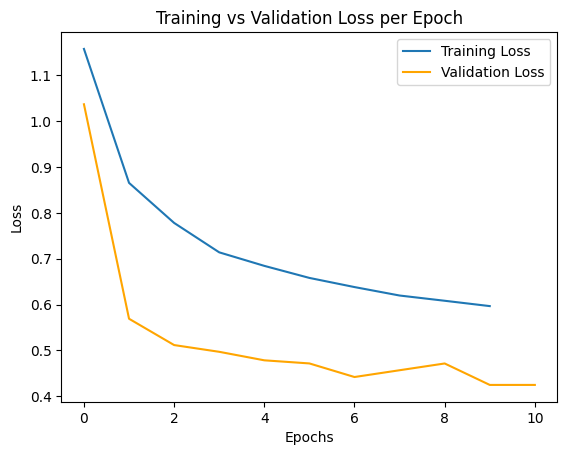

In [31]:
evaluator.plot_loss_history(best_models, best_model_name)

In [33]:
# evaluator.predict_on_val(
#     val_dataset=transformed_val_dataset,
#     best_models=best_models,
#     best_model_name=best_model_name,
# )

# **Key Conclusions and Recommendations for Improvement**


# **Key Conclusions:**

**High Model Accuracy:** The model achieved R² = 0.8808, meaning it explains 88.08% of the variance in the target variable, indicating strong predictive performance.

**Low Error:** Metrics MAE = 4.36, MAPE = 14.21%, and MSE = 30.73 (the primary metric used during training) indicate a relatively low average error, with predictions deviating by about 14% from actual values.

**Optimal Hyperparameters:** I tested architectures with both 3 layers [256, 128, 64] and 5 layers [256, 128, 64, 32, 16], with the 3-layer configuration performing better. Various hyperparameters were explored, including batch sizes (16, 32), learning rates (0.01, 0.001), dropout rates (0.1, 0.2, 0.3), and both the Adam and SGD optimizers, with SGD yielding the best results.

# **Model Architecture:**

**Hidden Layers:** The architecture consists of fully connected layers. The best-performing model used 3 hidden layers with 256, 128, and 64 neurons, alternating between ReLU and Tanh activations.

**Regularization:** Dropout layers with varying rates (0.1, 0.2, 0.3) were included after each hidden layer to prevent overfitting, with a 0.1 dropout rate proving optimal. This acts as a form of early stopping by reducing overfitting as the model trains.
Optimizer and Loss Function: The SGD optimizer combined with the mean squared error (MSE) loss function was used for training.

# **Recommendations:**

**Explore Deeper Architectures:** Although the 3-layer model performed better, further tuning of deeper architectures (5+ layers) with additional regularization techniques could be beneficial.

**Refine Dropout and Learning Rate:** Fine-tuning the dropout rates and using learning rate schedules could improve convergence and prevent overfitting. Dropout, already implemented in the model, acts as an early stopping mechanism by preventing overfitting during training.
Early Stopping and Optimization: Besides dropout, consider experimenting with more advanced early stopping strategies, combined with fine-tuning the learning rates for further optimization.
